In [2]:
import numpy as np
import pandas as pd

from nilearn import datasets
from nilearn.plotting import plot_matrix, show

/Users/oshima-alex/miniconda3/envs/myenv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# By default 2nd subject from haxby datasets will be fetched.
haxby_dataset = datasets.fetch_haxby()

# Print basic information on the dataset
print(f"Mask nifti images are located at: {haxby_dataset.mask}")
print(f"Functional nifti images are located at: {haxby_dataset.func[0]}")

func_filename = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask

# Load the behavioral data that we will predict
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels["labels"]
run = labels["chunks"]

# Remove the rest condition, it is not very interesting
non_rest = y != "rest"
y = y[non_rest]

# Get the labels of the numerical conditions represented by the vector y
unique_conditions, order = np.unique(y, return_index=True)
# Sort the conditions by the order of appearance
unique_conditions = unique_conditions[np.argsort(order)]

[get_dataset_dir] Dataset found in /Users/oshima-alex/nilearn_data/haxby2001
Mask nifti images are located at: /Users/oshima-alex/nilearn_data/haxby2001/mask.nii.gz
Functional nifti images are located at: /Users/oshima-alex/nilearn_data/haxby2001/subj2/bold.nii.gz


In [4]:
from nilearn.maskers import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(
    mask_img=mask_filename,
    standardize="zscore_sample",
    runs=run,
    smoothing_fwhm=4,
    memory="nilearn_cache",
    memory_level=1,
)
X = nifti_masker.fit_transform(func_filename)

# Remove the "rest" condition
X = X[non_rest]
run = run[non_rest]

X shape: (864, 39912)
y shape: (864,)


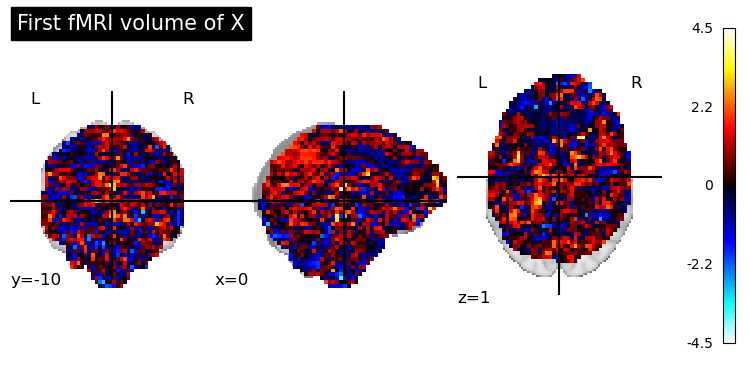


First 5 rows of X:
 [[ 0.69111603  3.210437    1.9961944  ...  0.76483     0.26460516
   1.3470215 ]
 [ 0.03183856  1.8330282   0.53699017 ...  0.05522097 -0.91839194
  -0.28928208]
 [-0.84448534  0.19465181  0.72767985 ...  1.1981351   0.26110956
   1.4098372 ]
 [-1.0294247  -1.3919485  -1.3682451  ... -0.32514268 -0.88887686
   0.13887714]
 [-0.396364    0.22978795  1.569099   ...  0.71279126 -0.31688282
   0.49756712]]

First 5 entries of y:
 6     scissors
7     scissors
8     scissors
9     scissors
10    scissors
Name: labels, dtype: object


In [ ]:
from nilearn.plotting import plot_stat_map

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Reconstruct the first volume back to a Nifti image
first_img = nifti_masker.inverse_transform(X[0])

# Plot it
plot_stat_map(first_img, display_mode="ortho", title="First fMRI volume of X")
show()

# Print first few entries
print("\nFirst 5 rows of X:\n", X[:5])
print("\nFirst 5 entries of y:\n", y.head())

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a linear SVM
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Overall accuracy
print("Overall accuracy:", accuracy_score(y_test, y_pred))

# Accuracy per class
print("\nAccuracy per class:")
print(classification_report(y_test, y_pred, target_names=unique_conditions))

# Confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred, labels=unique_conditions))

Overall accuracy: 0.9421965317919075

Accuracy per class:
              precision    recall  f1-score   support

    scissors       0.95      0.95      0.95        21
        face       0.91      1.00      0.95        21
         cat       0.91      0.95      0.93        22
        shoe       0.87      0.91      0.89        22
       house       1.00      0.86      0.93        22
scrambledpix       1.00      0.95      0.98        21
      bottle       1.00      1.00      1.00        22
       chair       0.91      0.91      0.91        22

    accuracy                           0.94       173
   macro avg       0.94      0.94      0.94       173
weighted avg       0.94      0.94      0.94       173

Confusion matrix:
[[20  0  0  0  0  0  0  1]
 [ 0 20  1  1  0  0  0  0]
 [ 0  0 21  0  0  0  0  0]
 [ 0  1  0 20  0  0  1  0]
 [ 0  2  0  0 19  0  0  1]
 [ 0  0  0  0  0 22  0  0]
 [ 0  0  1  0  0  0 20  0]
 [ 0  0  0  1  0  0  0 21]]
